# Metabolomic Analysis of Extraction Rat Urine (C18 Chromatography, Negative Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    library("matrixStats")
    library("devtools")
    library("ggpubr")
    
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.9)
than is installed on your system (1.0.10). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”


In [2]:
## List mzXML files
mzXMLs <- list.files(path = "~/Urin_Extraktion_Ratte/C18_neg", recursive = TRUE, 
                    full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Preparation_1_1", 5), rep("Preparation_1_2", 5), rep("Preparation_1_3", 5), 
                  rep("Preparation_2_1", 5), rep("Preparation_2_2", 5), rep("Preparation_2_3", 5), 
                  rep("Preparation_3_1", 5), rep("Preparation_3_2", 5), rep("Preparation_3_3", 5),
                  rep("Preparation_4_1", 5), rep("Preparation_4_2", 5),rep("Preparation_4_3", 5), rep("QC", 11))
sample.weight <- c(4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,
                   1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,NA,NA, NA, NA, NA, NA, NA, NA, NA, NA, NA)
sample.weight[is.na(sample.weight) == TRUE] <- mean(sample.weight, na.rm = TRUE) %>%
                                               round(0)
analysis.order <- c(54, 11, 62, 70, 23, 63, 17, 36, 51, 34, 55, 6, 31, 58, 14, 43, 25, 64, 44, 10, 42, 50, 61, 53, 
                  30, 33, 52, 40, 7, 9, 67, 69, 65, 46, 19, 28, 32, 45, 66, 22, 18, 39, 68, 24, 35, 37, 47, 8, 
                  20, 15, 56, 57, 48, 29, 59, 41, 21, 12, 26, 13, 1, 2, 3, 4, 5, 16, 27, 38, 49, 60, 71)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   sample_weight = sample.weight,
                   analysis_order = analysis.order,
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [3]:
## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of TIC

In [4]:
## Define colours for experimental groups
group.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13])
names(group.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")

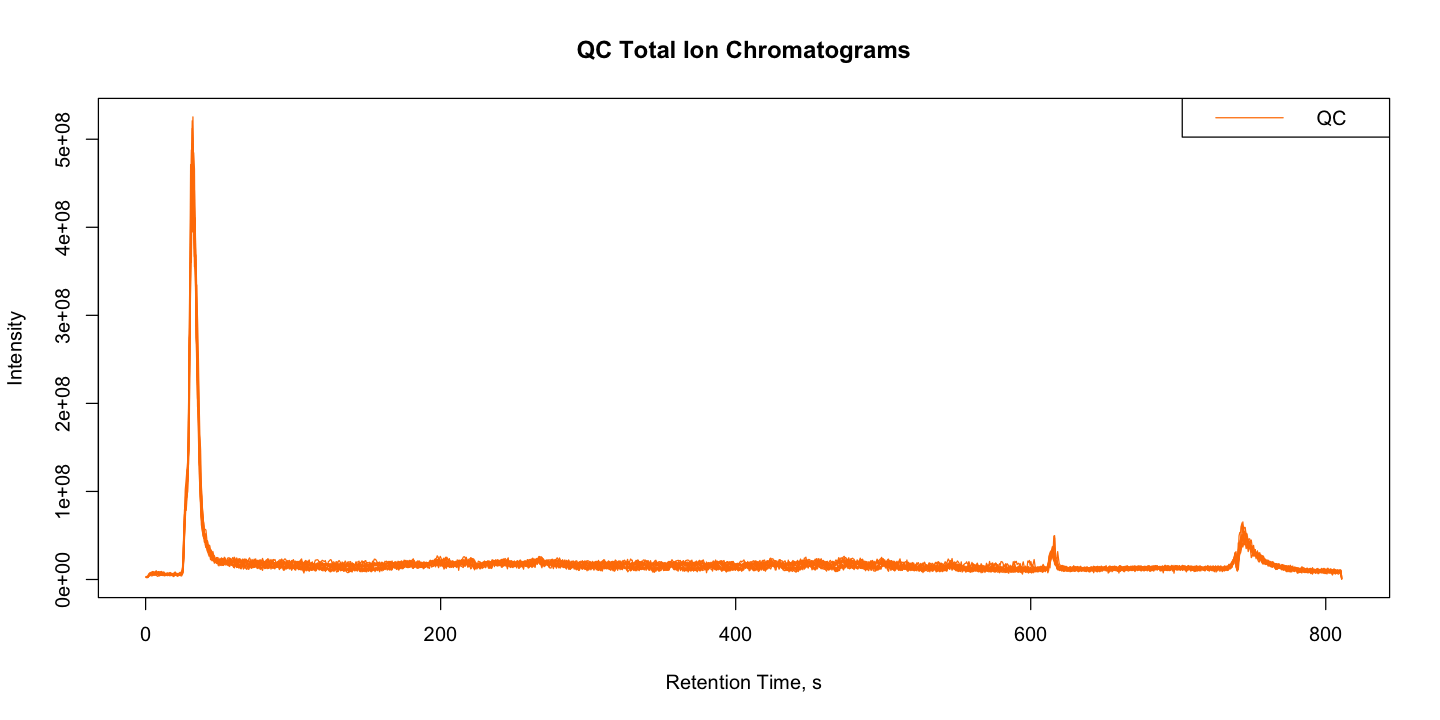

In [5]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

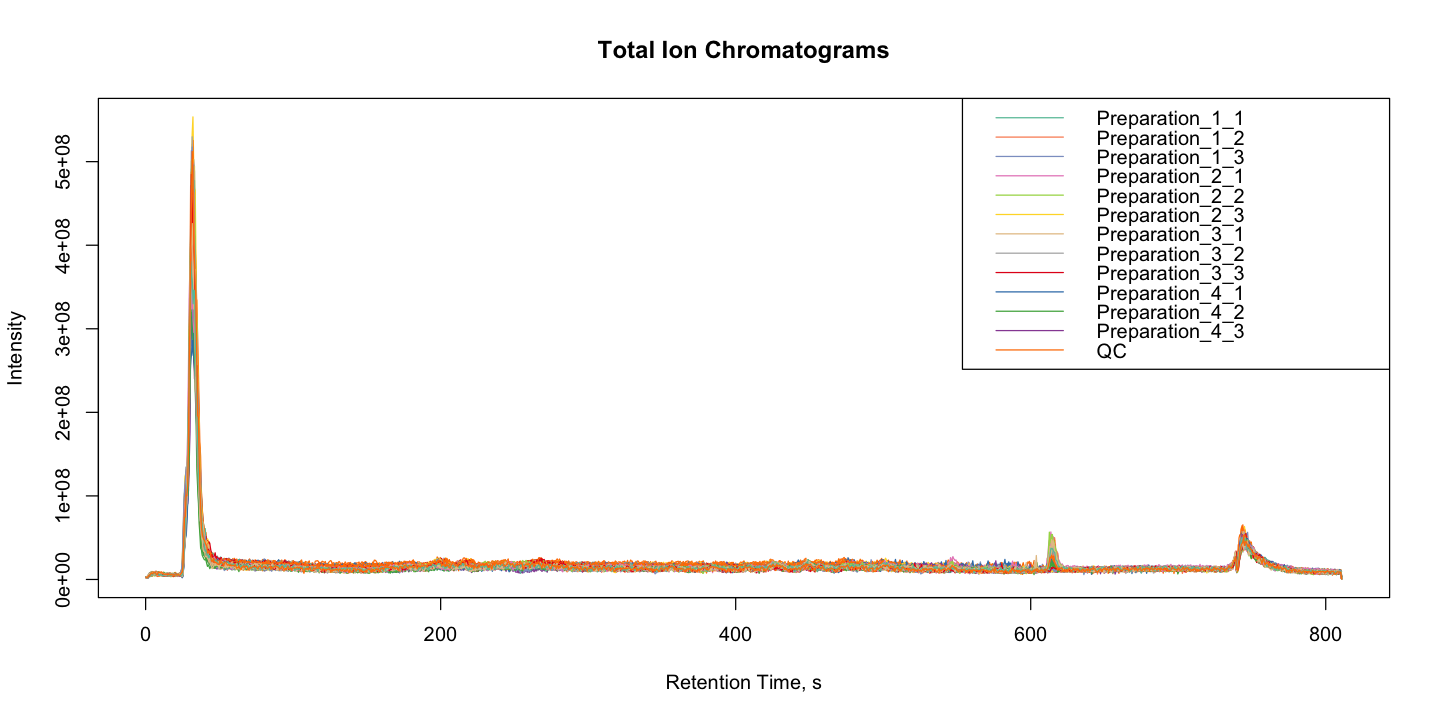

In [6]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

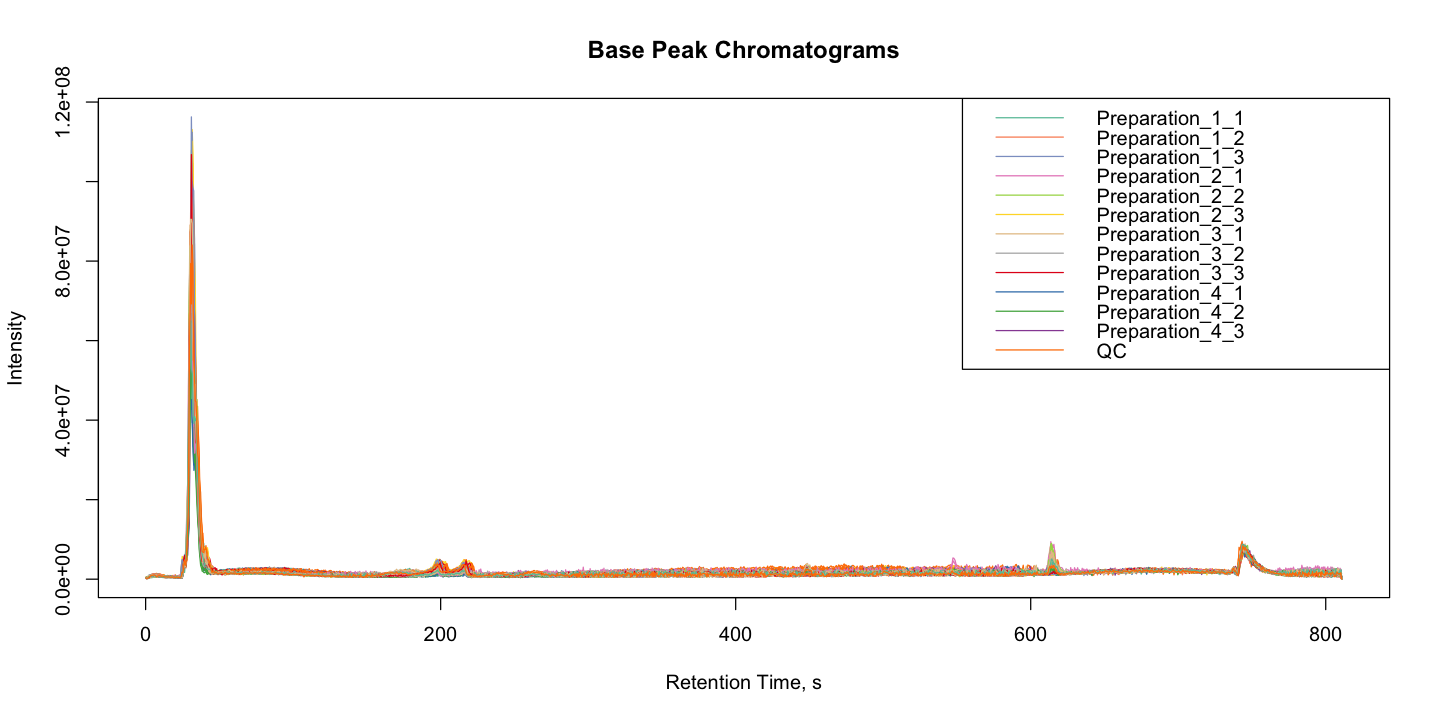

In [7]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

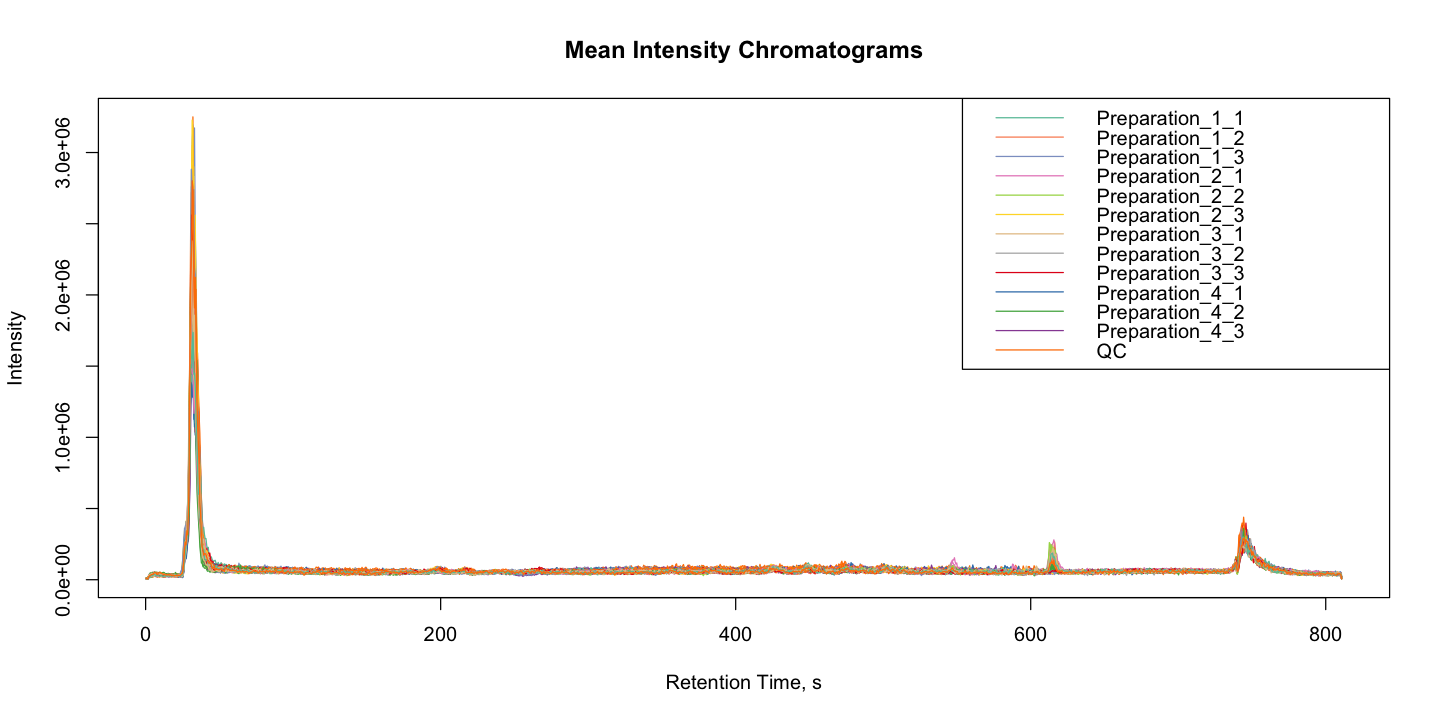

In [8]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

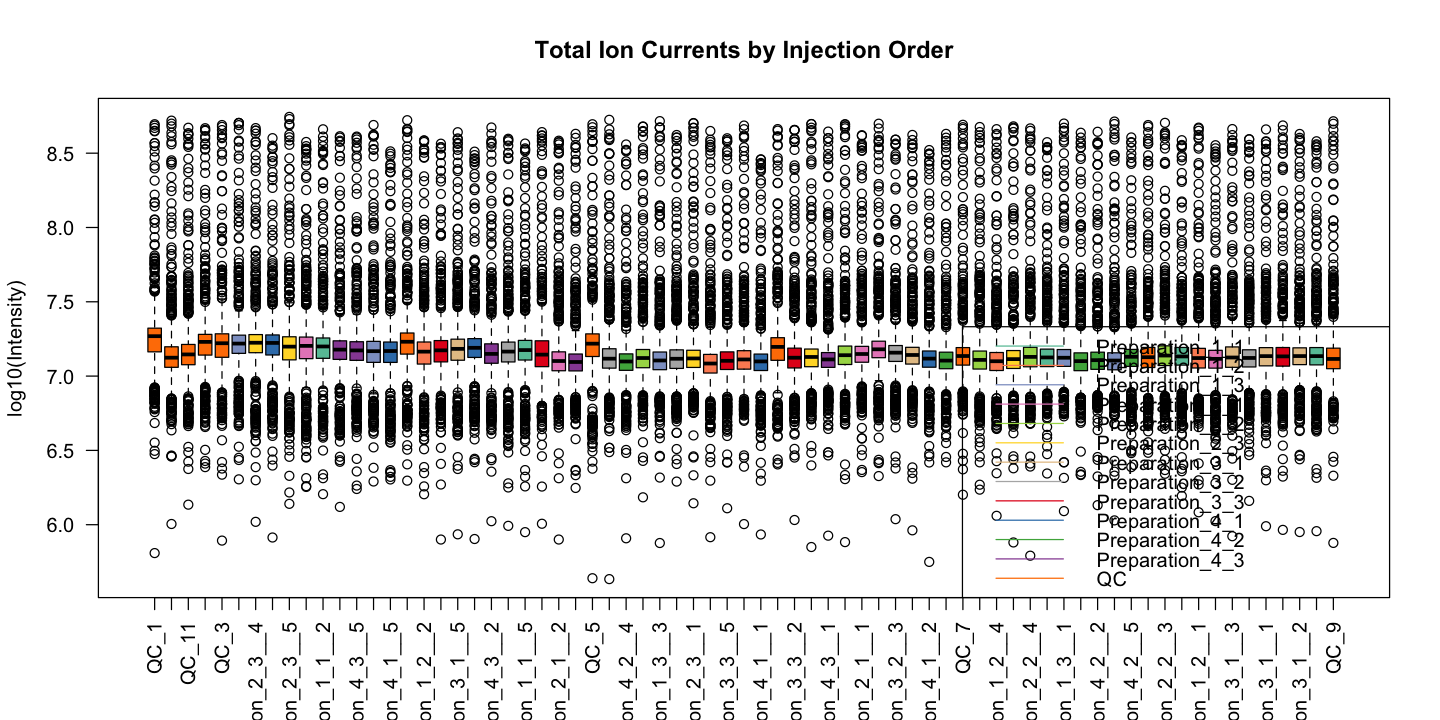

In [9]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

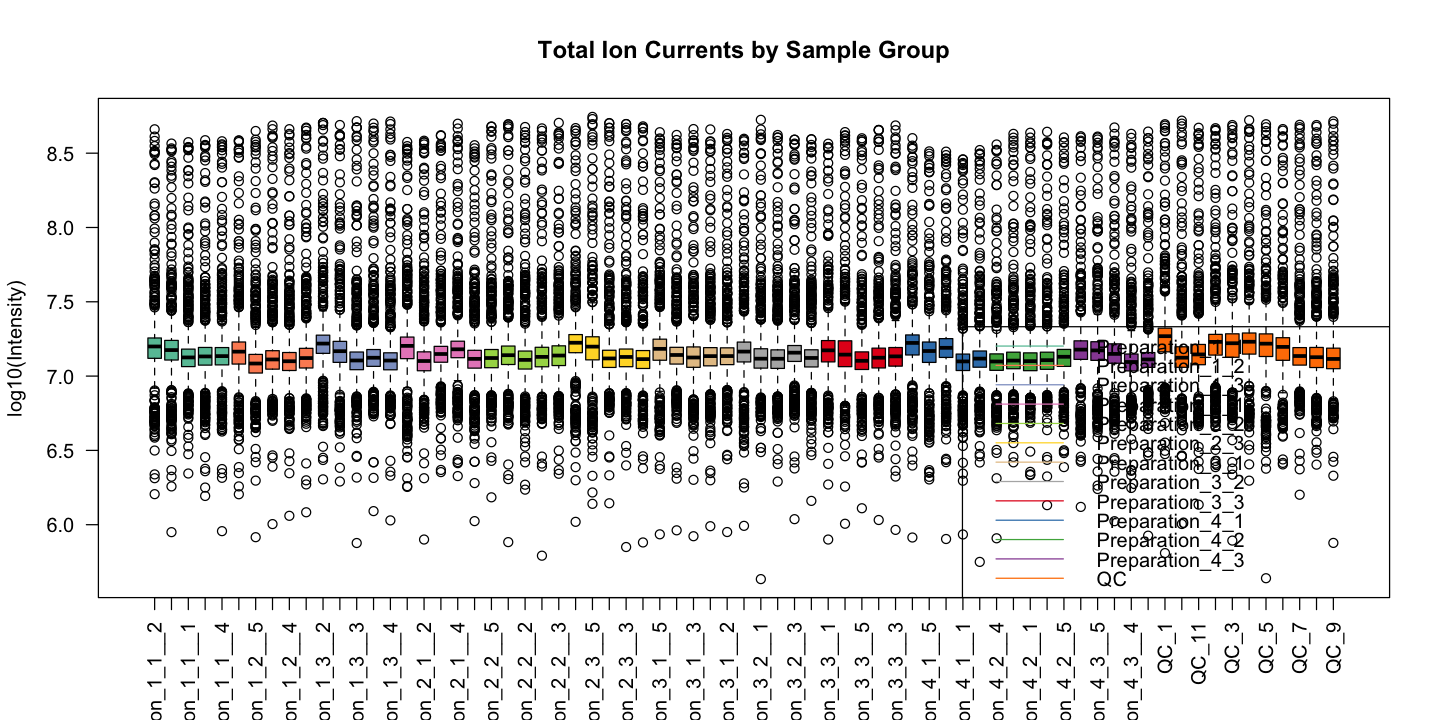

In [10]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [11]:
cwp <- CentWaveParam(peakwidth = c(8.9, 15), ppm = 2.5, snthresh = 83, 
                     mzdiff = 0.098,  prefilter = c(10, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [12]:
## Define sample colours
sample.colours <- paste0(c(brewer.pal(8, name = "Set2"),brewer.pal(5, name = "Set1")) [1:13], "60")
names(sample.colours) <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
sample.colours <- sample.colours[raw$sample_group]

### Retention Time Correction (RT)

In [13]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 1.0)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.4)
    set <- adjustRtime(set, param = pgp)
    
})

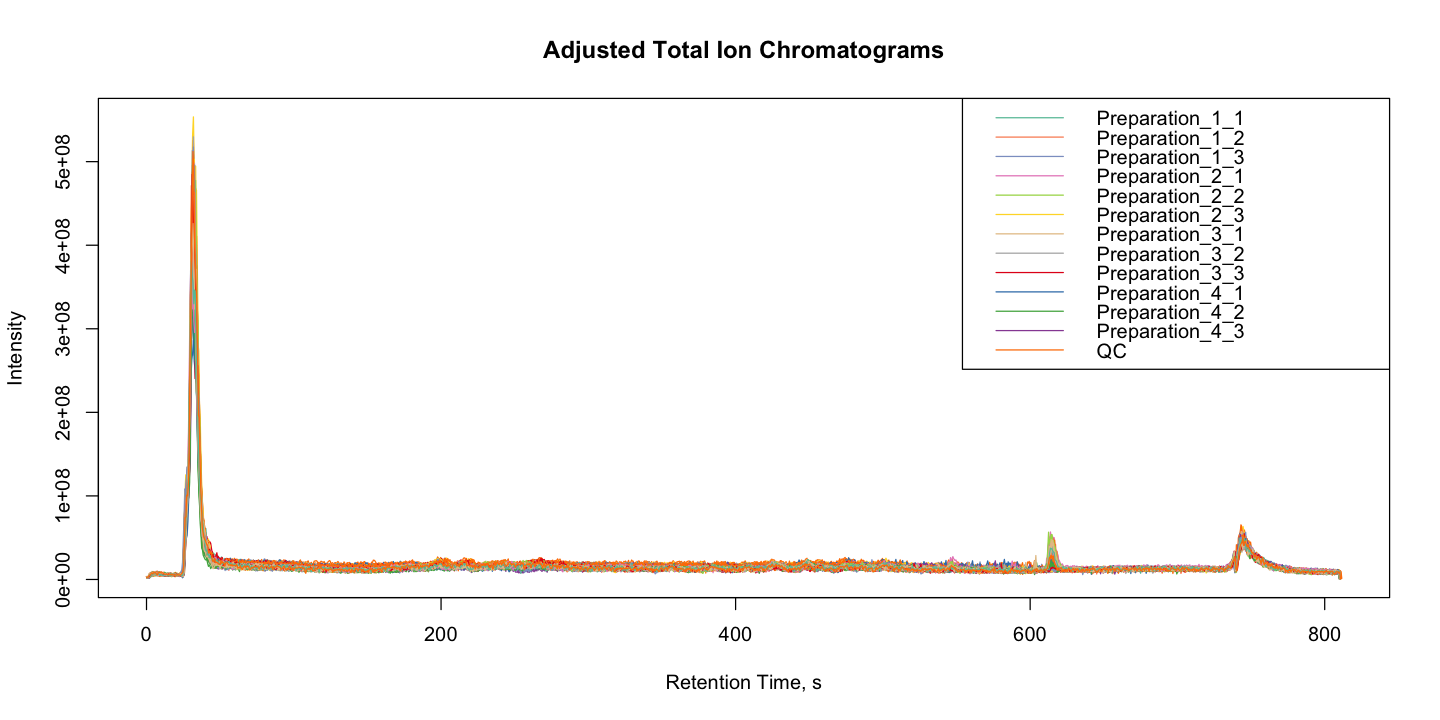

In [14]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

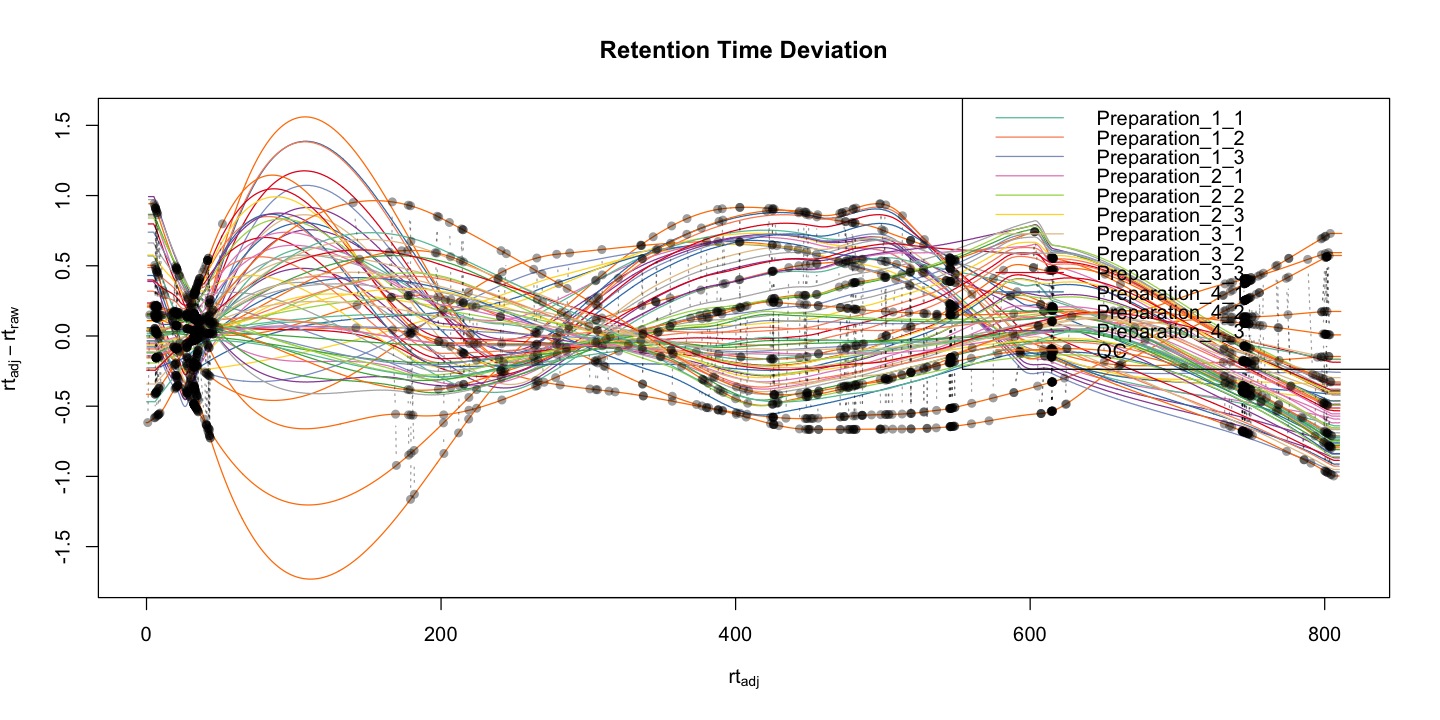

In [15]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [16]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

### Peak Filling

In [17]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [18]:
## Summarise experiment
results <- quantify(set, value = "into")

In [19]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [20]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "negative") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 105 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 19 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 105 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 105 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  260 
xsAnnotate has now 260 groups, instead of 105 
Generating peak matrix for peak annotation!

Calculating possible adducts in 260 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


In [21]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Rat_Urine_Extraction_C18_neg_count.xlsx")

### Scaling
Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at [DOI: 10.1007/s11306-016-1015-8](https://doi.org/10.1007/s11306-016-1015-8). The surrogate LOD is the lowest area that was measured during the analysis.

In [22]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

In [23]:
# Create separate (scaled) assay results within same object
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

## Normalisation to Extraction solvent

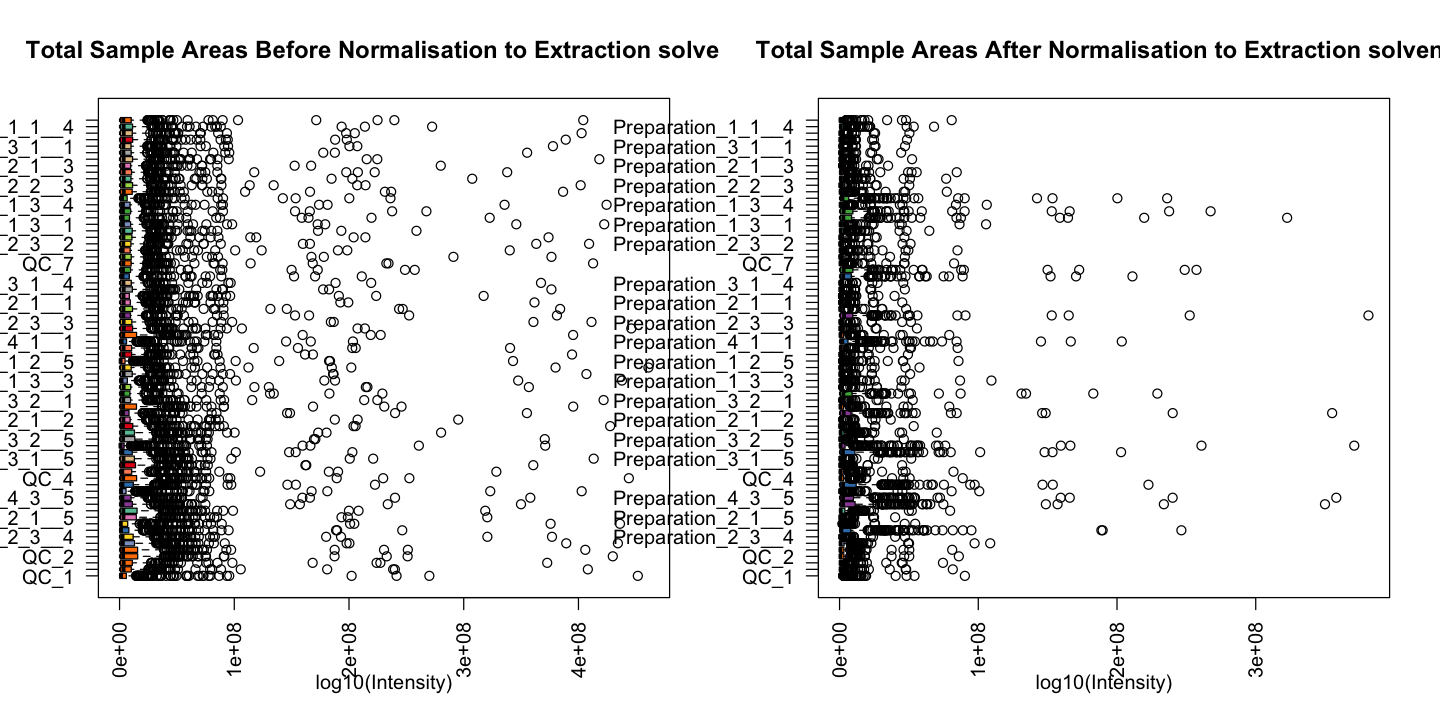

In [24]:
## Normalise data to extraction solvent
norm.weight <- function(x, weight){x / weight}

assay(results, "norm.weight") <- apply(assay(results, "raw"), 1, 
                                       norm.weight, weight = colData(results)$sample_weight) %>%
                                 t()

## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("raw") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation to Extraction solvent", las = 2)

results %>%
assay("norm.weight") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation to Extraction solvent", las = 2)

# IS Area for IS in Extraction Solvents
- Carnitine-d9: m/z 171.1690 (neg:170.1617), rt 31 sec (HILIC 454 sec)
- D-Fructose 13C6: m/z (neg:185.0762), rt 30 sec (HILIC 433 sec)
- Glutamic acid d3: m/z 151.0793 (neg:149.0647), rt 29 sec (HILIC 493 sec)
- Hypoxanthine d4:  m/z 141.0709 (neg:139.0563), rt / sec (HILIC / sec)
- Kynurenic acid d5: m/z 195.0813 (neg:193.0667), rt 177 sec (HILIC 341 sec)
- Lysin d3: m/z 150.1316, rt 26 sec (HILIC 500 sec)
- Palmitic acid d31: m/z (neg:286.4275), rt 617 sec (HILIC 52 sec)
- Prostaglandin E2 d9: m/z (neg: 360.2742), rt 343 sec (HILIC 182 sec)
- Succinic acid d4: m/z (neg:121.0444), rt 34 sec (HILIC 464 sec)
- Tryptophan d5: m/z 210.1285 (neg:208.1140), rt 172 sec (HILIC 392 sec)

In [25]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

### Fructose 13C 

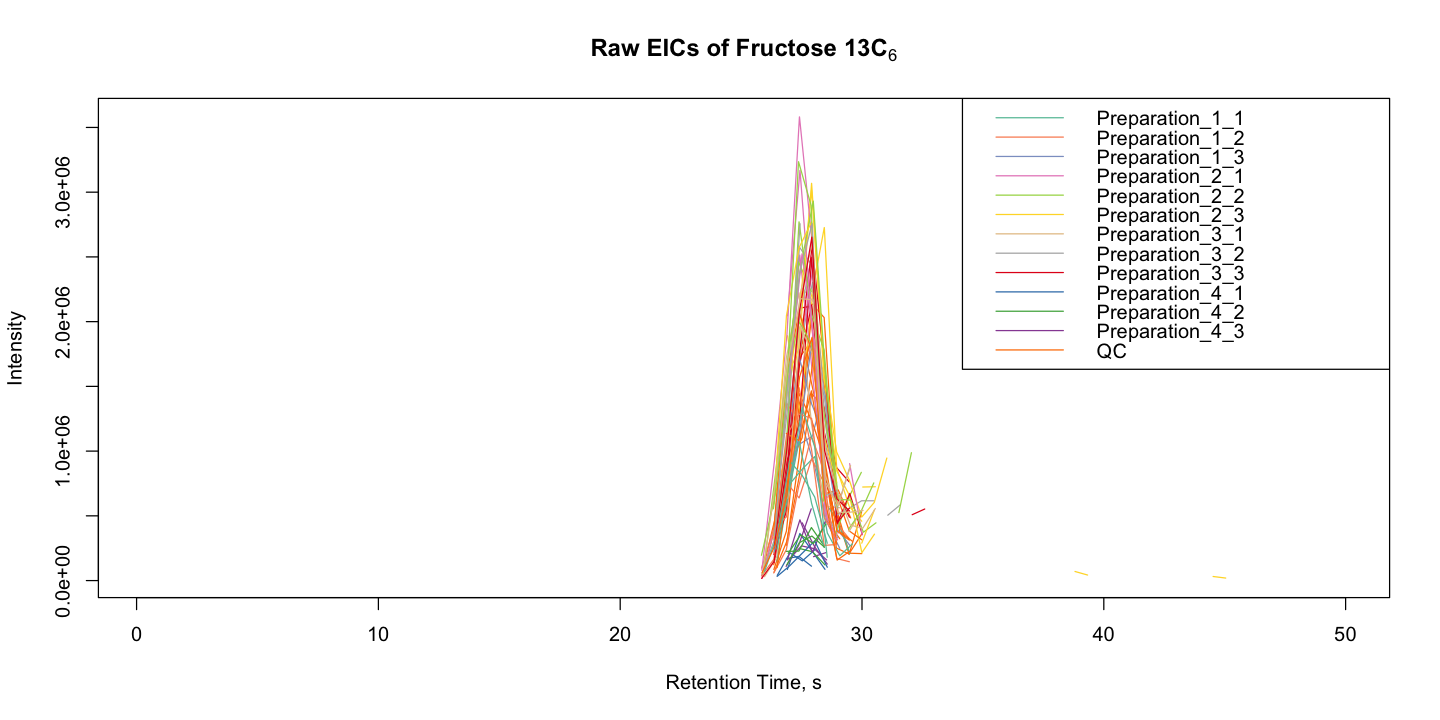

In [26]:
## Plot Fructose before processing
frucC6.raw <- chromatogram(raw, mz = c(185.0757, 185.0767), rt = c(0, 50))

plot(frucC6.raw, col = group.colours[frucC6.raw$sample_group], 
     main = bquote(bold("Raw EICs of Fructose 13C"[6])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [27]:
## Identify rownumber of internal standard Palmitic acid d31
frucC6 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 185.0760, rt = 28, 5, 10)
frucC6 %>% head()

integer(0)

### Palmitic acid d31

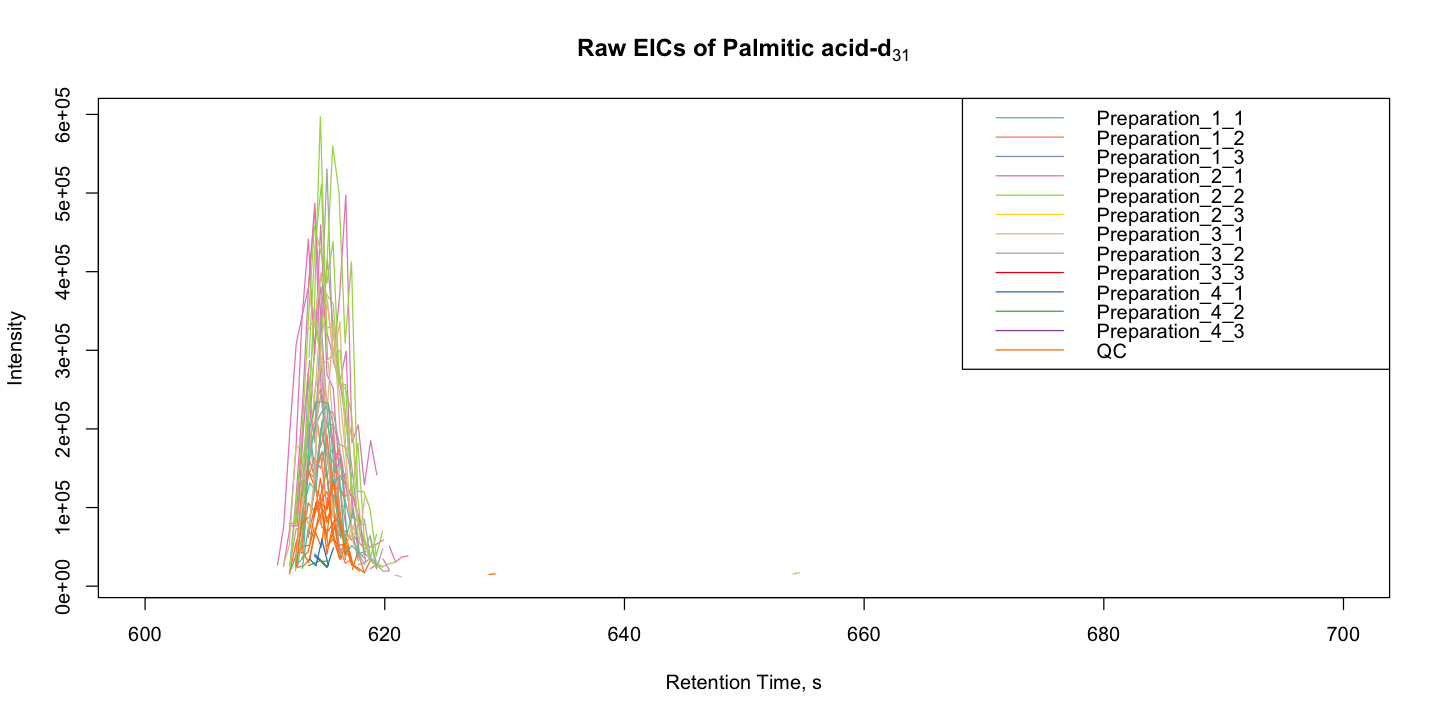

In [28]:
## Plot Palmitic acid d31 before processing
pald31.raw <- chromatogram(raw, mz = c(286.4270, 286.4280), rt = c(600, 700))

plot(pald31.raw, col = group.colours[pald31.raw$sample_group], 
     main = bquote(bold("Raw EICs of Palmitic acid-d"[31])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [29]:
## Identify rownumber of internal standard Palmitic acid d31
pald31 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 286.4275, rt = 617, 5, 10)
pald31 %>% head()

[1] 355

In [30]:
peaklist <- results %>%
assay("norm.weight")
pald31 <- peaklist[355,]
area <- data.frame(pald31)
preparation <- colData(results)$sample_group
pald31 <- cbind(area, preparation)
pald31 %>% head()

pald31     preparation    
QC_1.mzXML               49758.3954 QC             
QC_10.mzXML              48312.1974 QC             
QC_11.mzXML              53999.7281 QC             
QC_2.mzXML               73447.9143 QC             
QC_3.mzXML               68493.6717 QC             
Preparation_1_3__2.mzXML   744.6189 Preparation_1_3

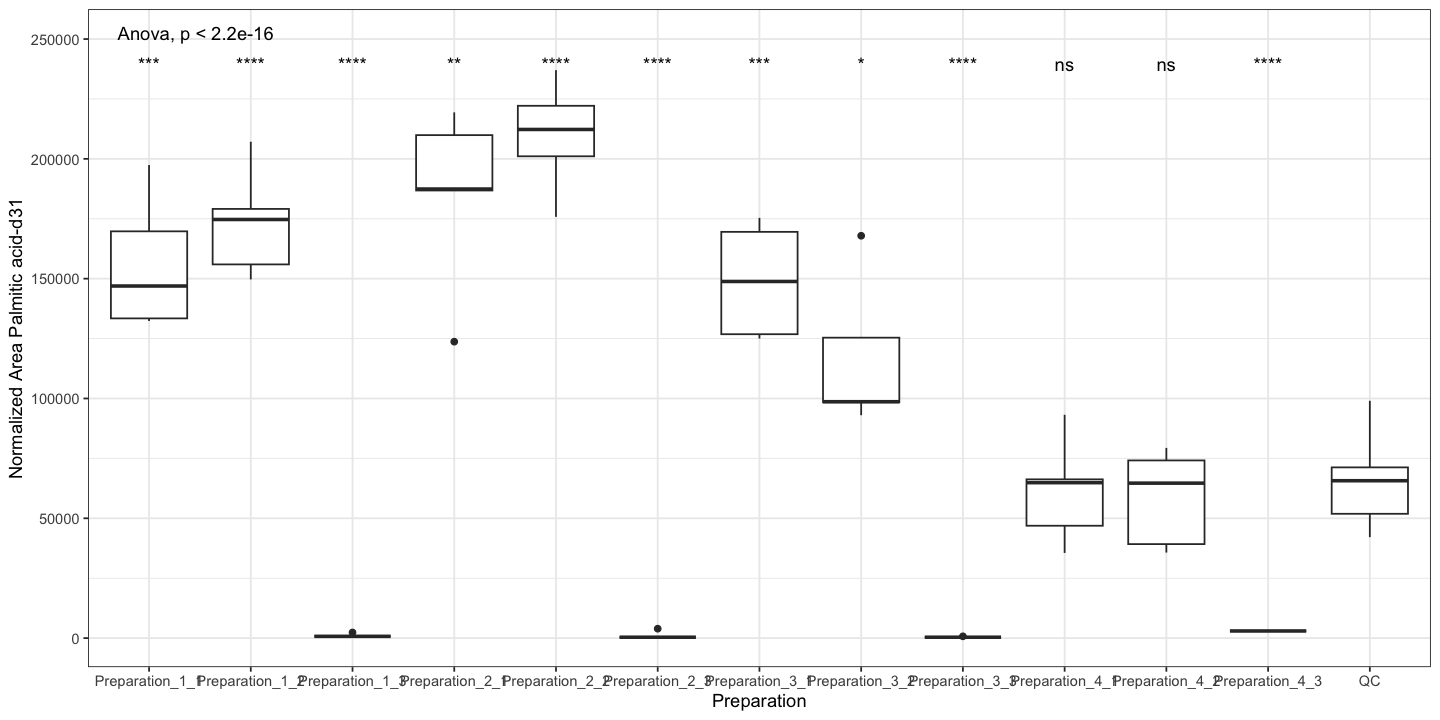

In [31]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(pald31, aes(x = factor(preparation), y = pald31)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y=2.5e+05)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Palmitic acid-d31") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Prostaglandin E2 d9

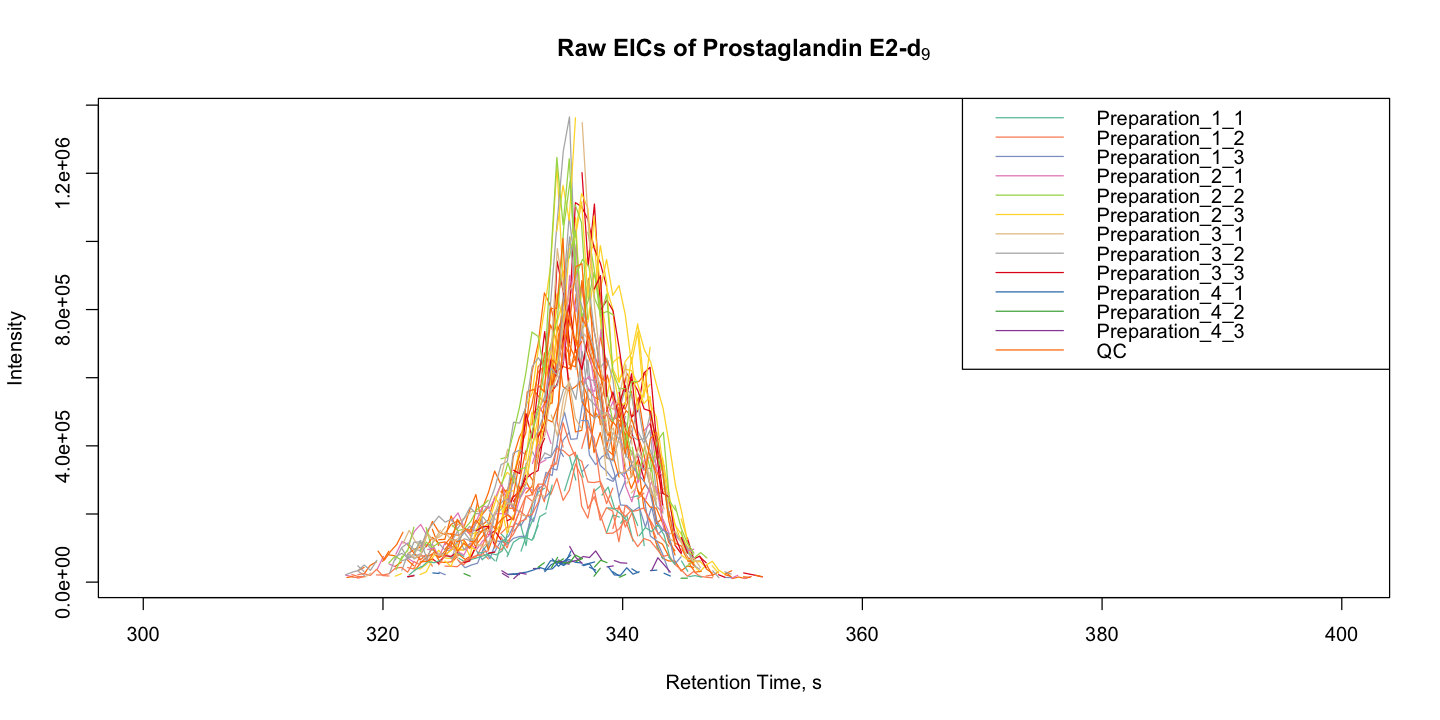

In [32]:
## Plot Prostaglandin E2 d9 before processing
proE2.raw <- chromatogram(raw, mz = c(360.2737, 360.2747), rt = c(300, 400))

plot(proE2.raw, col = group.colours[proE2.raw$sample_group], 
     main = bquote(bold("Raw EICs of Prostaglandin E2-d"[9])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [33]:
## Identify rownumber of internal standard Prostaglandin E2 d9
proE2 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 360.2742, rt = 343, 5, 10)
proE2 %>% head()

[1] 413

In [34]:
peaklist <- results %>%
assay("norm.weight")
proE2 <- peaklist[413,]
area <- data.frame(proE2)
extraction <- colData(results)$sample_group
proE2 <- cbind(area, extraction)
proE2 %>% head()

proE2   extraction     
QC_1.mzXML               1579605 QC             
QC_10.mzXML              1517081 QC             
QC_11.mzXML              1579647 QC             
QC_2.mzXML               1587106 QC             
QC_3.mzXML               1375001 QC             
Preparation_1_3__2.mzXML 1052231 Preparation_1_3

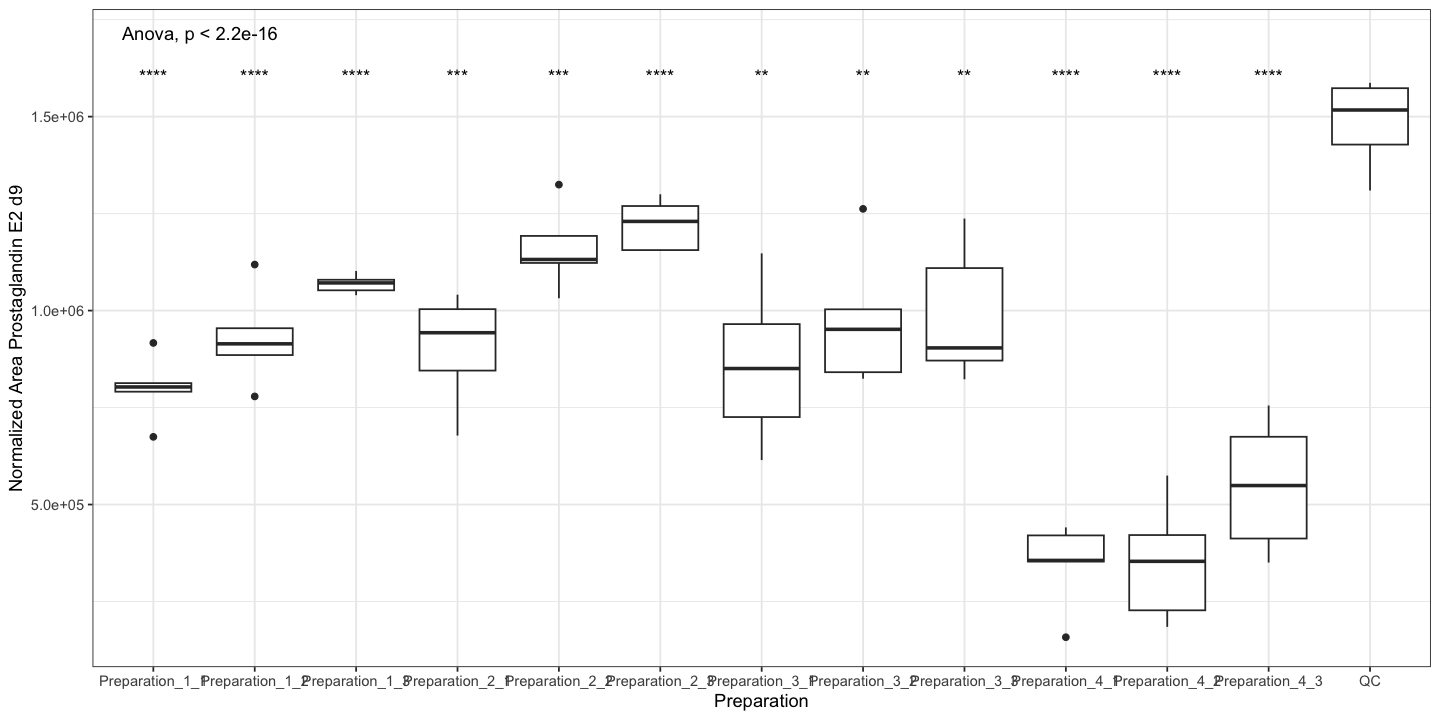

In [35]:
## Plot Area of IS of all extractions
ggplot(proE2, aes(x = factor(preparation), y = proE2)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 1.7e+06)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Normalized Area Prostaglandin E2 d9") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

### Trp-d5

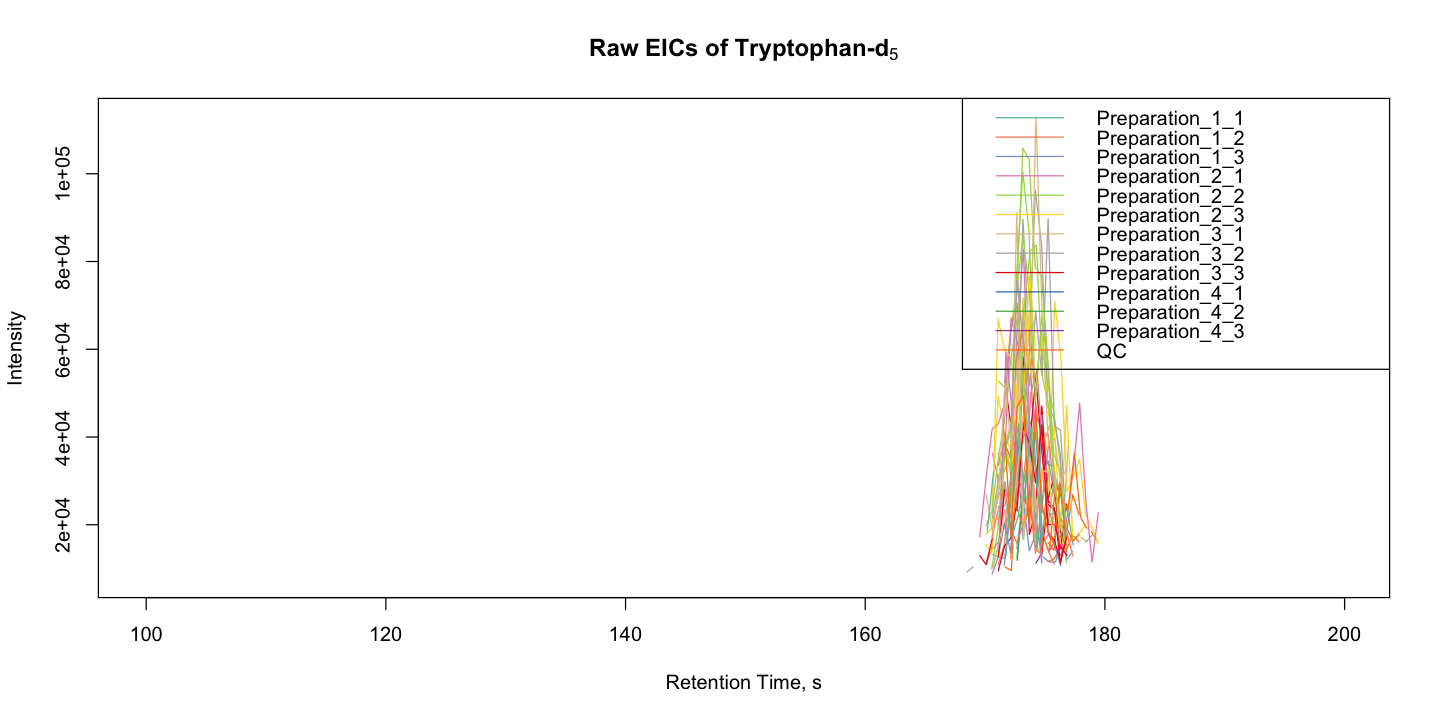

In [36]:
## Plot Prostaglandin E2 d9 before processing
trpd5.raw <- chromatogram(raw, mz = c(208.1130, 208.1150), rt = c(100, 200))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [37]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 208.1140, rt = 172, 5, 10)
trpd5 %>% head()

[1] 255

In [38]:
peaklist <- results %>%
assay("norm.weight")
trpd5 <- peaklist[255,]
area <- data.frame(trpd5)
preparation <- colData(results)$sample_group
trpd5 <- cbind(area, preparation)
trpd5 %>% head()

trpd5     preparation    
QC_1.mzXML               14750.616 QC             
QC_10.mzXML              26788.498 QC             
QC_11.mzXML              33617.112 QC             
QC_2.mzXML                7322.268 QC             
QC_3.mzXML                3907.433 QC             
Preparation_1_3__2.mzXML  5974.100 Preparation_1_3

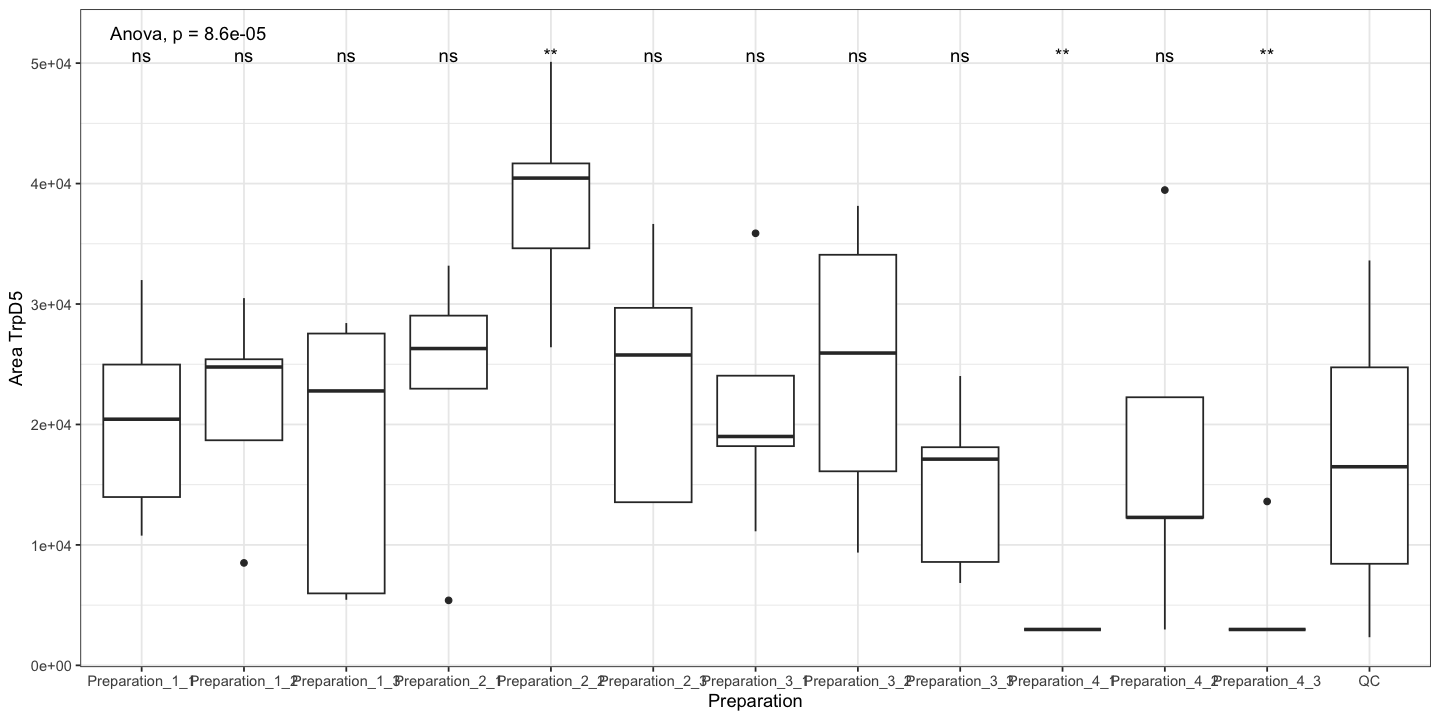

In [39]:
## Plot Area IS of all extractions to Reference Group QC
ggplot(trpd5, aes(x = factor(preparation), y = trpd5)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 5.2e+04)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "QC") +
  xlab("Preparation") +
  ylab("Area TrpD5") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")) +
  theme_bw()

## IS Area for IS in Reconstitution Solvent 

Positive:
- Arginine d7: m/z 182.1629, rt 28 sec (HILIC 500 sec)
- Aspartic acid d3: m/z 137.0636, rt 28 sec (HILIC 498 sec)
- Creatinine d3: m/z 117.0850, rt 30 sec (HILIC 285 sec)
- Cytosine d2: m/z 114.0631, rt 30 sec (HILIC 329 sec)
- Glycin N15: m/z 77.0363 (neg:75.0218), rt / sec (HILIC / sec)
- Thymidine d4: m/z 247.1227, rt 0 sec (HILIC 198 sec)

Negative:
- Arginine d7: m/z 180.1483, rt 28 sec (HILIC 500 sec)
- Aspartic acid d3: m/z 135.0491, rt 28 sec (HILIC 498 sec)
- Cortisol d4: m/z 365.2271, rt 598 sec (HILIC / sec)
- Glucose d7: m/z 186.1000, rt 29 sec (HILIC 456 sec)
- Stearic acid 13C: m/z 284.2676, rt / sec (HILIC 69 sec)
- Thymidine d4: m/z 245.1081, rt 0 sec (HILIC 198 sec)

### Glucose d7

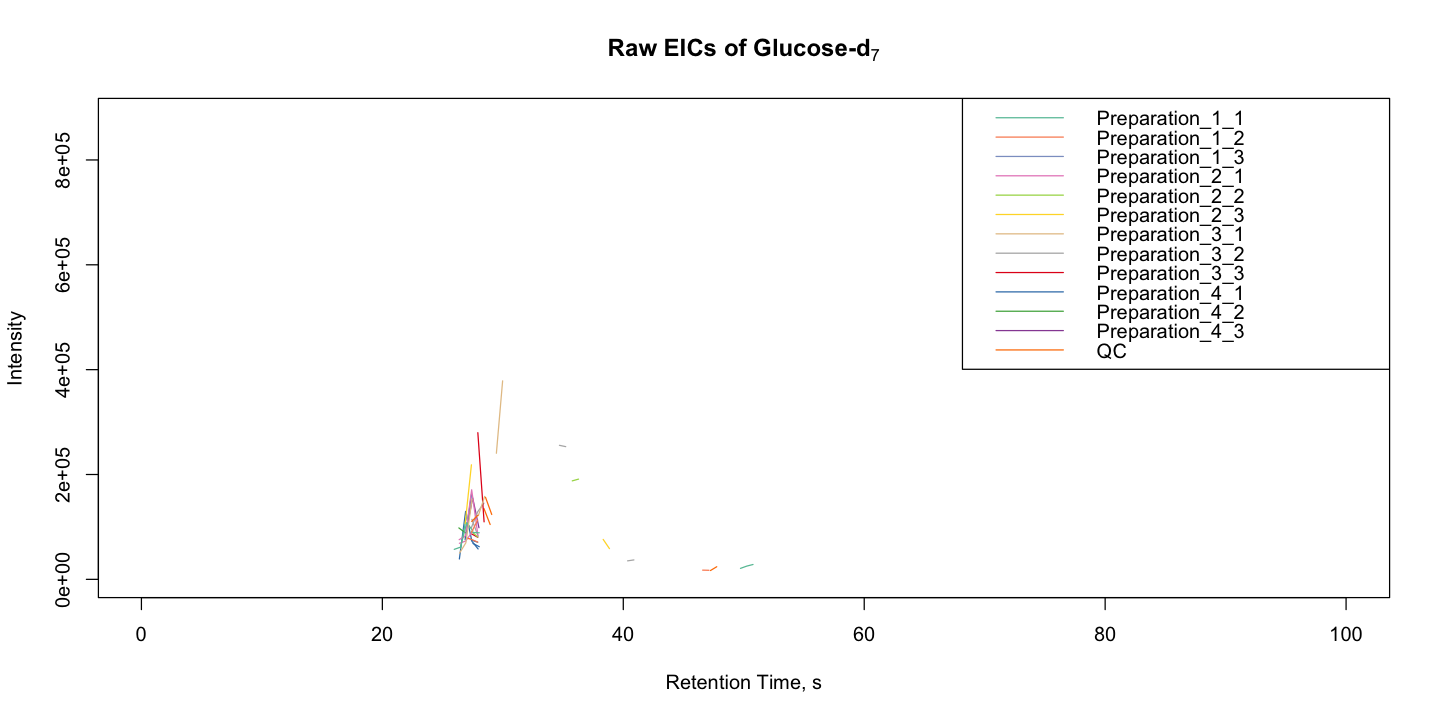

In [40]:
## Plot Prostaglandin E2 d9 before processing
glucd7.raw <- chromatogram(raw, mz = c(186.0095, 186.1010), rt = c(0, 100))

plot(glucd7.raw, col = group.colours[glucd7.raw$sample_group], 
     main = bquote(bold("Raw EICs of Glucose-d"[7])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

In [41]:
write_xlsx(list(pald31 = as.data.frame(pald31), 
                trpd5 = as.data.frame(trpd5),
                proE2 = as.data.frame(proE2)), 
           "Rat_Urine_Extraction_C18_neg_IS.xlsx")

## Feature Summary for all IS

In [42]:
Summaryfeature <- featureSummary(set, set$sample_group , perSampleCounts = TRUE, method = "maxint", skipFilled = TRUE)
Summaryfeature %>% head()

count perc     multi_count multi_perc rsd       QC_count QC_perc  
FT001 26    36.61972 0           0.000000   0.2454398 5        45.454545
FT002 21    29.57746 0           0.000000   0.2812167 5        45.454545
FT003 21    29.57746 0           0.000000   0.3995331 4        36.363636
FT004 14    19.71831 1           7.142857   0.4006647 3        27.272727
FT005 15    21.12676 0           0.000000   0.2468692 3        27.272727
FT006 14    19.71831 0           0.000000   0.4150498 1         9.090909
      QC_multi_count QC_multi_perc QC_rsd    ⋯ Preparation_1_1__3.mzXML
FT001 0               0.00000      0.1945978 ⋯ 0                       
FT002 0               0.00000      0.2337756 ⋯ 0                       
FT003 0               0.00000      0.2726044 ⋯ 0                       
FT004 1              33.33333      0.5059083 ⋯ 0                       
FT005 0               0.00000      0.1774335 ⋯ 0                       
FT006 0               0.00000             NA ⋯ 0                       
      Preparation_1_2__1.mzXML Preparation_2_1__3.mzXML
FT001 0                        1                       
FT002 0                        1                       
FT003 0                        1                       
FT004 0                        0                       
FT005 0                        1                       
FT006 0                        1                       
      Preparation_3_1__3.mzXML Preparation_3_2__4.mzXML
FT001 0                        1                       
FT002 0                        1                       
FT003 0                        1                       
FT004 0                        1                       
FT005 0                        1                       
FT006 0                        0                       
      Preparation_3_1__1.mzXML Preparation_3_3__3.mzXML
FT001 0                        0                       
FT002 0                        0                       
FT003 0                        0                       
FT004 0                        0                       
FT005 0                        0                       
FT006 0                        0                       
      Preparation_3_1__2.mzXML Preparation_1_1__4.mzXML QC_9.mzXML
FT001 1                        1                        0         
FT002 1                        1                        0         
FT003 1                        1                        0         
FT004 1                        1                        0         
FT005 1                        1                        0         
FT006 1                        0                        0

In [43]:
write_xlsx(as.data.frame(Summaryfeature), "Summaryfeature.xlsx")

In [44]:
peakdata <- as.data.frame(rowData(results))
IS <- Summaryfeature[c(255,355,413),]
#IS.peakdata <- peakdata[c(286,318,739,757,1085,1263,1469,1695),]
#SumFeat <- cbind(IS.peakdata, c(IS))
IS %>% head()

count perc     multi_count multi_perc rsd       QC_count QC_perc  
FT255 13    18.30986 0           0          0.2583529  0         0.00000
FT355 25    35.21127 0           0          0.4376262  2        18.18182
FT413 60    84.50704 0           0          0.4155924 11       100.00000
      QC_multi_count QC_multi_perc QC_rsd     ⋯ Preparation_1_1__3.mzXML
FT255 0              0                     NA ⋯ 0                       
FT355 0              0             0.21453055 ⋯ 0                       
FT413 0              0             0.06413482 ⋯ 1                       
      Preparation_1_2__1.mzXML Preparation_2_1__3.mzXML
FT255 0                        0                       
FT355 0                        0                       
FT413 1                        1                       
      Preparation_3_1__3.mzXML Preparation_3_2__4.mzXML
FT255 1                        0                       
FT355 0                        0                       
FT413 1                        1                       
      Preparation_3_1__1.mzXML Preparation_3_3__3.mzXML
FT255 1                        0                       
FT355 1                        0                       
FT413 1                        1                       
      Preparation_3_1__2.mzXML Preparation_1_1__4.mzXML QC_9.mzXML
FT255 1                        0                        0         
FT355 1                        1                        1         
FT413 1                        1                        1

In [45]:
write_xlsx(as.data.frame(IS), "Summaryfeature.IS.xlsx")

## Export data set for additional evaluations

In [63]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Rat_Urine_Extraction_C18_neg_count.xlsx")

# Feature Count

## Save dataset

In [64]:
save.image("Rat_Urine_Extraction_C18_neg_sig.RData")

In [65]:
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [66]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

## Feature Count

In [67]:
peaklist <- results %>%
assay("raw")
peaklist <- as.data.frame(t(peaklist))
peaklist %>% head()
write.csv(peaklist, "peaklist.csv")

FT001    FT002   FT003   FT004    FT005     FT006  
QC_1.mzXML                3971839      NA 4377812 606540.8  346227.7 1298830
QC_10.mzXML               7791916 4489946 3799807 960376.1 2311552.2 1701866
QC_11.mzXML               6167704 3105940 1796256 231272.8 1869949.2 1283359
QC_2.mzXML                9466326 5484390 3307532 858419.7 1453166.3 1847838
QC_3.mzXML               10055440 5192048 3169658 868334.2 1834890.9 1699503
Preparation_1_3__2.mzXML 10956673 5484918 3820637 978673.2 1738609.7 1850046
                         FT007      FT008     FT009     FT010      ⋯ FT438     
QC_1.mzXML                 951003.9 1383613.3  330244.4   25958.42 ⋯  543252.58
QC_10.mzXML               6802569.1 1520633.8 1642934.3 3934854.62 ⋯  618116.91
QC_11.mzXML               7114945.8  157140.2 1374804.0  278799.16 ⋯  545262.05
QC_2.mzXML                8813816.0 1438469.3  933000.8 3557217.93 ⋯ 1220577.12
QC_3.mzXML                9130254.6 1591770.2 1083209.6 3858884.61 ⋯ 1712683.87
Preparation_1_3__2.mzXML 10484962.4 2013000.3 1347543.2 4299418.99 ⋯   68344.76
                         FT439    FT440     FT441    FT442   FT443    FT444   
QC_1.mzXML               411695.4 296590.89       NA      NA       NA 159472.4
QC_10.mzXML              291409.4 465832.12 580767.6 1295302 311826.4 251141.8
QC_11.mzXML              203524.7 528221.64 552154.6 1144038 305186.1 260375.5
QC_2.mzXML               348941.4 330311.62       NA      NA       NA 158343.7
QC_3.mzXML               284254.3 343549.86       NA      NA       NA 152240.3
Preparation_1_3__2.mzXML       NA  59647.36       NA      NA       NA       NA
                         FT445      FT446   FT447   
QC_1.mzXML               3602927.37 1460631       NA
QC_10.mzXML              5223707.31 2114585 462404.4
QC_11.mzXML              5019101.02 1908302 383006.3
QC_2.mzXML               3449147.79 1280529       NA
QC_3.mzXML               3409266.44 1197550       NA
Preparation_1_3__2.mzXML   40455.47      NA       NA

In [68]:
## Plot feature count (peaknumber)
peaklist[peaklist == 0] <- NA
peaklist[is.na(peaklist) == FALSE] <- 1
peaklist[is.na(peaklist) == TRUE] <- 0
#peaklist$Sum <- apply(peaklist, 1, sum)
count <- apply(peaklist, 1, sum)
count <- as.data.frame(count)
preparation <- colData(results)$sample_group
preparation <- as.data.frame(preparation)
peaklist <- cbind(peaklist, c(count), c(preparation))

peaknumber_order <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3", "QC")
peaklist <- peaklist[!(row.names(peaklist) %in% c("QC_1.mzXML","QC_2.mzXML","QC_3.mzXML","QC_4.mzXML","QC_5.mzXML",
                                                 "QC_6.mzXML","QC_7.mzXML","QC_8.mzXML","QC_9.mzXML","QC_10.mzXML","QC_11.mzXML")),]
peaklist %>% head()
#count %>% head()

FT001 FT002 FT003 FT004 FT005 FT006 FT007 FT008 FT009
Preparation_1_3__2.mzXML 1     1     1     1     1     1     1     1     1    
Preparation_2_3__4.mzXML 1     1     1     1     1     1     1     1     1    
Preparation_4_1__3.mzXML 1     1     1     1     1     1     1     1     1    
Preparation_2_3__5.mzXML 1     1     1     1     1     1     1     1     1    
Preparation_2_1__5.mzXML 1     1     1     1     1     1     1     1     1    
Preparation_1_1__2.mzXML 1     1     1     1     1     1     1     1     1    
                         FT010 ⋯ FT440 FT441 FT442 FT443 FT444 FT445 FT446
Preparation_1_3__2.mzXML 1     ⋯ 1     0     0     0     0     1     0    
Preparation_2_3__4.mzXML 1     ⋯ 1     0     0     0     1     1     1    
Preparation_4_1__3.mzXML 1     ⋯ 1     0     0     0     1     1     1    
Preparation_2_3__5.mzXML 1     ⋯ 1     1     0     0     1     1     1    
Preparation_2_1__5.mzXML 1     ⋯ 1     0     0     0     1     1     1    
Preparation_1_1__2.mzXML 1     ⋯ 1     0     0     0     1     1     1    
                         FT447 count preparation    
Preparation_1_3__2.mzXML 0     427   Preparation_1_3
Preparation_2_3__4.mzXML 0     435   Preparation_2_3
Preparation_4_1__3.mzXML 0     411   Preparation_4_1
Preparation_2_3__5.mzXML 0     408   Preparation_2_3
Preparation_2_1__5.mzXML 0     435   Preparation_2_1
Preparation_1_1__2.mzXML 0     435   Preparation_1_1

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
ℹ Please use `gather()` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


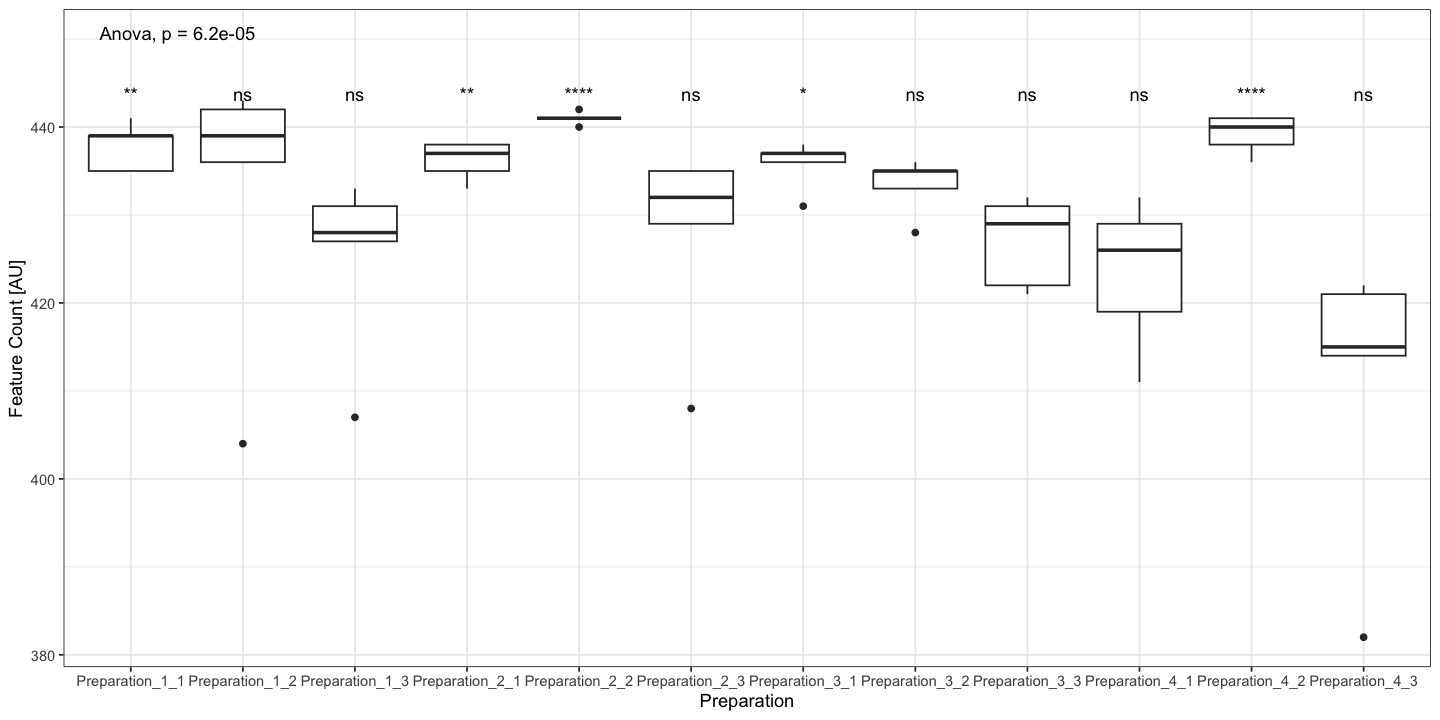

In [69]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 450)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = ".all.") +
  xlab("Preparation") +
  ylab("Feature Count [AU]") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

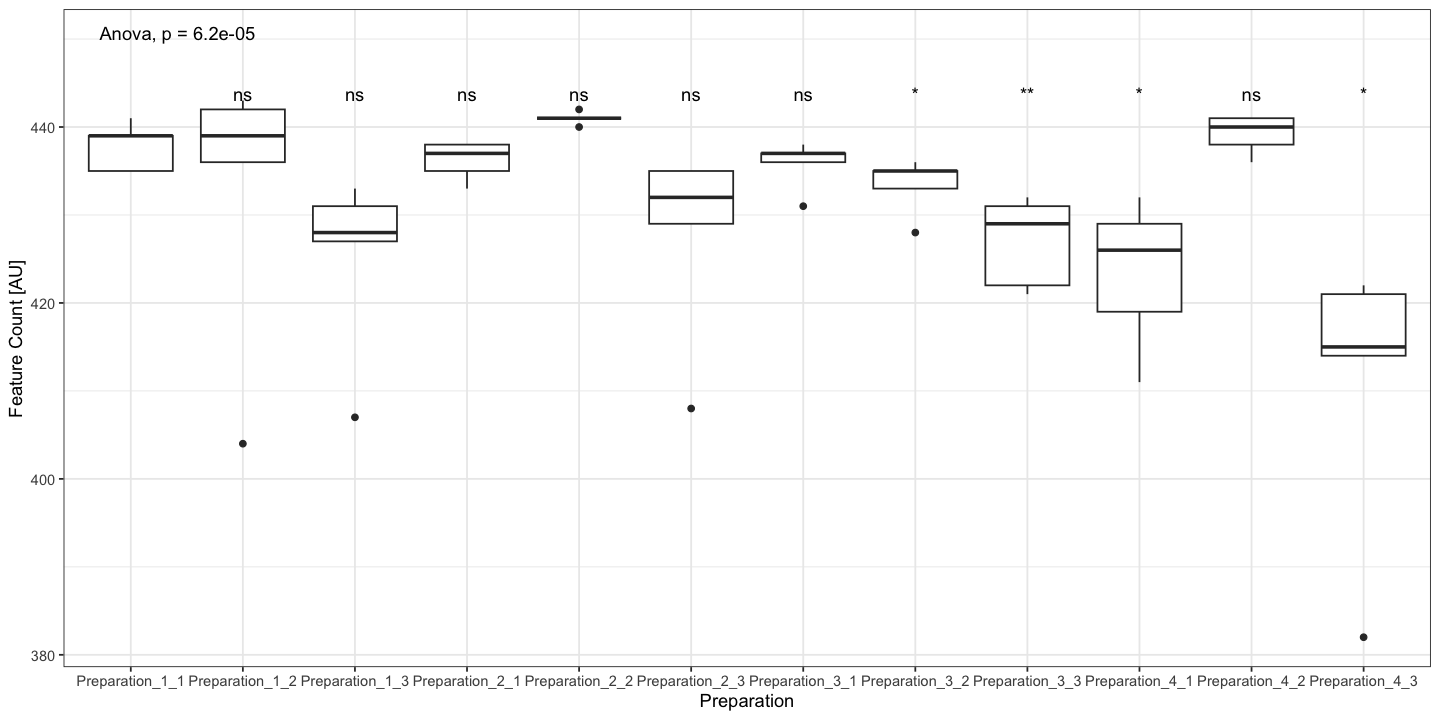

In [70]:
## Plot peaknumber of all extractions
ggplot(peaklist, aes(x = factor(preparation, level = peaknumber_order), y = count)) +
  geom_boxplot(aes(group = preparation),) +
  stat_compare_means(method = "anova", label.y = 450)+
  stat_compare_means(label = "p.signif", method = "t.test", ref.group = "Preparation_1_1") +
  xlab("Preparation") +
  ylab("Feature Count [AU]") +
  scale_x_discrete(limits = c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                          "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                          "Preparation_4_2", "Preparation_4_3")) +
  theme_bw()

In [71]:
## Export Feature Count Table
Peaknumber_Results <- as.data.frame(count)
colnames(Peaknumber_Results) <- "Feature_count"
Peaknumber_Results$Sample <- rownames(count)
write.csv(Peaknumber_Results, "Feature_Count.csv")

# Feature Count CV<20

In [72]:
Preparation_1_1 <- results[,results$sample_group == "Preparation_1_1"] %>%
               assay("raw")
cv <- apply(Preparation_1_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_1_cv <- cbind(Preparation_1_1,c(cv))
Preparation_1_1_cv20 <- Preparation_1_1_cv[which(cv <= 20),]
Preparation_1_1_cv20 <- nrow(Preparation_1_1_cv20)

Preparation_1_2 <- results[,results$sample_group == "Preparation_1_2"] %>%
               assay("raw")
cv <- apply(Preparation_1_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_2_cv <- cbind(Preparation_1_2,c(cv))
Preparation_1_2_cv20 <- Preparation_1_2_cv[which(cv <= 20),]
Preparation_1_2_cv20 <-nrow(Preparation_1_2_cv20)
            
Preparation_1_3 <- results[,results$sample_group == "Preparation_1_3"] %>%
               assay("raw")
cv <- apply(Preparation_1_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_1_3_cv <- cbind(Preparation_1_3,c(cv))
Preparation_1_3_cv20 <- Preparation_1_3_cv[which(cv <= 20),]
Preparation_1_3_cv20 <- nrow(Preparation_1_3_cv20)
            
Preparation_2_1 <- results[,results$sample_group == "Preparation_2_1"] %>%
               assay("raw")
cv <- apply(Preparation_2_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_1_cv <- cbind(Preparation_2_1,c(cv))
Preparation_2_1_cv20 <- Preparation_2_1_cv[which(cv <= 20),]
Preparation_2_1_cv20 <- nrow(Preparation_2_1_cv20)
            
Preparation_2_2 <- results[,results$sample_group == "Preparation_2_2"] %>%
               assay("raw")
cv <- apply(Preparation_2_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_2_cv <- cbind(Preparation_2_2,c(cv))
Preparation_2_2_cv20 <- Preparation_2_2_cv[which(cv <= 20),]
Preparation_2_2_cv20 <- nrow(Preparation_2_2_cv20)
            
Preparation_2_3 <- results[,results$sample_group == "Preparation_2_3"] %>%
               assay("raw")
cv <- apply(Preparation_2_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_2_3_cv <- cbind(Preparation_2_3,c(cv))
Preparation_2_3_cv20 <- Preparation_2_3_cv[which(cv <= 20),]
Preparation_2_3_cv20 <- nrow(Preparation_2_3_cv20)
            
Preparation_3_1 <- results[,results$sample_group == "Preparation_3_1"] %>%
               assay("raw")
cv <- apply(Preparation_3_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_1_cv <- cbind(Preparation_3_1,c(cv))
Preparation_3_1_cv20 <- Preparation_3_1_cv[which(cv <= 20),]
Preparation_3_1_cv20 <- nrow(Preparation_3_1_cv20)
            
Preparation_3_2 <- results[,results$sample_group == "Preparation_3_2"] %>%
               assay("raw")
cv <- apply(Preparation_3_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_2_cv <- cbind(Preparation_3_2,c(cv))
Preparation_3_2_cv20 <- Preparation_3_2_cv[which(cv <= 20),]
Preparation_3_2_cv20 <- nrow(Preparation_3_2_cv20)
            
Preparation_3_3 <- results[,results$sample_group == "Preparation_3_3"] %>%
               assay("raw")
cv <- apply(Preparation_3_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_3_3_cv <- cbind(Preparation_3_3,c(cv))
Preparation_3_3_cv20 <- Preparation_3_3_cv[which(cv <= 20),]
Preparation_3_3_cv20 <- nrow(Preparation_3_3_cv20)
            
Preparation_4_1 <- results[,results$sample_group == "Preparation_4_1"] %>%
               assay("raw")
cv <- apply(Preparation_4_1, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_1_cv <- cbind(Preparation_4_1,c(cv))
Preparation_4_1_cv20 <- Preparation_4_1_cv[which(cv <= 20),]
Preparation_4_1_cv20 <- nrow(Preparation_4_1_cv20)  
            
Preparation_4_2 <- results[,results$sample_group == "Preparation_4_2"] %>%
               assay("raw")
cv <- apply(Preparation_4_2, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_2_cv <- cbind(Preparation_4_2,c(cv))
Preparation_4_2_cv20 <- Preparation_4_2_cv[which(cv <= 20),]
Preparation_4_2_cv20 <- nrow(Preparation_4_2_cv20) 
            
Preparation_4_3 <- results[,results$sample_group == "Preparation_4_3"] %>%
               assay("raw")
cv <- apply(Preparation_4_3, 1, function(x) sd(x, na.rm=T)/mean(x, na.rm=T)*100)
Preparation_4_3_cv <- cbind(Preparation_4_3,c(cv))
Preparation_4_3_cv20 <- Preparation_4_3_cv[which(cv <= 20),]
Preparation_4_3_cv20 <- nrow(Preparation_4_3_cv20)

In [73]:
Preparation_CV20 <- c("Preparation_1_1" = Preparation_1_1_cv20, "Preparation_1_2" = Preparation_1_2_cv20,
                   "Preparation_1_3" = Preparation_1_3_cv20, "Preparation_2_1" = Preparation_2_1_cv20, 
                   "Preparation_2_2" = Preparation_2_2_cv20, "Preparation_2_3" = Preparation_2_3_cv20,
                   "Preparation_3_1" = Preparation_3_1_cv20, "Preparation_3_2" = Preparation_3_2_cv20,
                   "Preparation_3_3" = Preparation_3_3_cv20, "Preparation_4_1" = Preparation_4_1_cv20, 
                   "Preparation_4_2" = Preparation_4_2_cv20, "Preparation_4_3" = Preparation_4_3_cv20)
preparation <- c("Preparation_1_1", "Preparation_1_2", "Preparation_1_3", "Preparation_2_1", "Preparation_2_2",
                      "Preparation_2_3", "Preparation_3_1", "Preparation_3_2", "Preparation_3_3", "Preparation_4_1", 
                      "Preparation_4_2", "Preparation_4_3")
Preparation_CV20 <- cbind(Preparation_CV20, c(preparation))
Preparation_CV20 <- as.data.frame(Preparation_CV20)

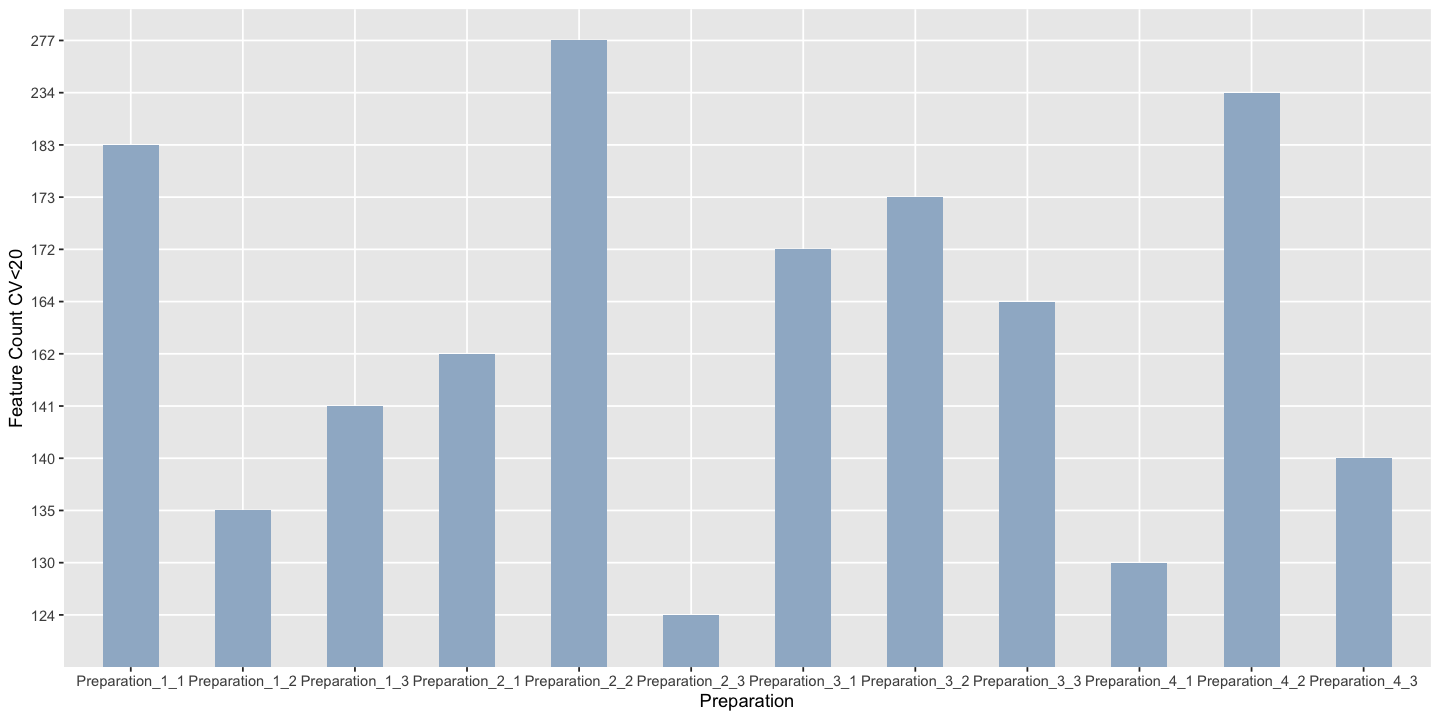

In [74]:
ggplot(Preparation_CV20, aes(preparation, Preparation_CV20))+
geom_col(fill="slategray3", width = 0.5)+
xlab("Preparation") +
ylab("Feature Count CV<20") 

In [75]:
write.csv(Preparation_CV20, "Feature_Count_CV20.csv")

In [76]:
save.image("Rat_Urine_Extraction_C18_neg_count.RData")

# Appendix

In [77]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.5.0                devtools_2.4.5             
 [3] usethis_2.1.6               writexl_1.4.2              
 [5] ggrepel_0.9.3               MASS_7.3-58.2              
 [7] caret_6.0-93                lattice_0.20-45            
 [9] Rtsne_0.16                  gplots_3.1.3               
[11] forcats_1.0.0               stringr_1.5.0              
[13] dplyr_1.1.0                 purrr_1.0.1                
[15] readr_2.1.4                 tidyr_1.3.0          